# Falling particle

This notebook illustrates the calculation of the falling velocity of a single
particle falling through the F-layer. It also shows the boundary layer thickeness
analysis. This material is described in section 3(a) of the manuscript. The 
notebook includes code used to generate Figure 3.

Most code for this notebook lives in the `falling` python module (see the `falling.py`
file; this does not rely on our other modules).

In [1]:
# Import modules and setup plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import falling

## Falling velocity

Particles in the slurry are denser than the liquid and will quickly accelerate to 
fall at their terminal velocity. The simplest estimate of the particle velocity is 
based on Stokes flow, which gives the terminal velocity of 
the particle by balancing buoyancy and drag forces:

$$w_{\mathrm{stokes}} = \frac{2}{9} \frac{(\rho^L - \rho^S) g r_p^2}{\eta^L}.$$

This applies at low Reynolds number ($Re = \frac{2r_p|w|}{\eta^L}$)
when the fluid motion changes from laminar. As the velocity (and $Re$) increases 
so does the drag compared to that in the laminar regime. We follow
Zhang and Xu (2003) and utilise an empirical relation for the relation for the drag
coefficient valid for $Re \le 3\times10^5$:

$$C_D = \frac{24}{Re} (1 + 0.15Re^{0.687}) + \frac{0.421}{1 + 42500Re^{-1.16}}$$

(note that the PDF and web version of Zhang and Xu differ for this equation) together
with the definition of the drag coefficient to find the falling velocity:

$$w_p = \sqrt{\left( \frac{8}{3} \frac{(\rho^L - \rho^S)  g r_p}{\rho^L C_D} \right) }.$$ 

Because $Re$ depends on $w_p$ these are found self consistently.

The drag coefficient $C_D$ is 

$$ C_D = \frac{2F_D}{\rho^L w_p^2 A}.$$

If $F_D = 6\pi \mu a$ as given by Stokes drag then we can take $w_p=w_\mathrm{Zhang}$ in the equation 
for $C_D$, which becomes $C_D = (12 \pi \mu a) / (\rho_l w_\mathrm{Zhang} A)$. Subbing into the 
original eqn for $w_\mathrm{Zhang}$ and noting that the area $A\sim\pi a^2$ we recover the 
Stokes velocity.

As $Re$ increases the drag coefficient increases and so $w_\mathrm{Zhang}$ tends to decrease
compared to $w_\mathrm{Stokes}$. Hence the falling time should be greater for the high $Re$
case than the low $Re$ case at high $Re$. This provides a check on the results below
where we show how $w_{\mathrm{Zhang}}$ and $w_{\mathrm{Stokes}}$ are the same
for small particle radius and low $Re$ and how they diverge at higher $Re$. 

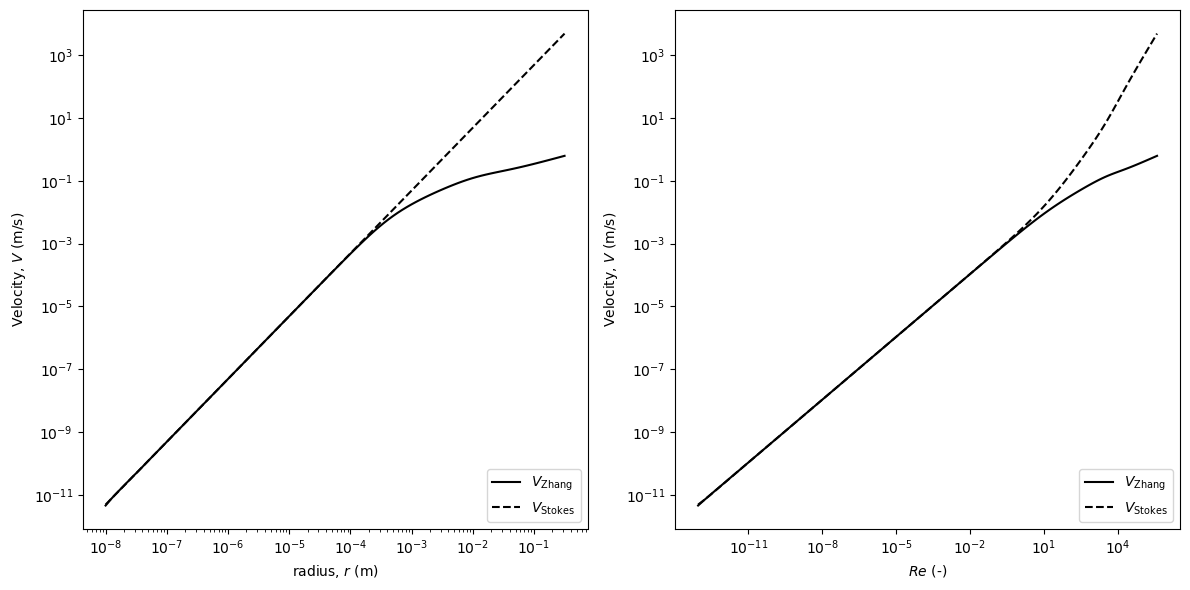

In [2]:
# Do calculation for some radii
r = np.logspace(-8,-0.5,num=100)

# Estimated typical F-layer properties
kinematic_viscosity = 1.0E-6     # kinematic viscosity
gravity = 4.4                    # At ICB
rho_l = 12100                    # liquid density
rho_s = 12700                    # solid density
delta_density = rho_s - rho_l


# V_Zhang and Re from self consistent calculation
falling_velocity, re, _ = falling.self_consistent_falling_velocity(r, kinematic_viscosity, 
                                                gravity, delta_density, rho_l)

# V_Stokes - in the paper we write this in terms of dynamic viscosity.
stokes_velocity = falling.stokes_falling_velocity(r, kinematic_viscosity,
                                                  gravity, delta_density, rho_l)

fig, axs = plt.subplots(ncols=2, figsize=(12,6), tight_layout=True)
ax = axs[0]
ax.plot(r, falling_velocity, label="$V_{\mathrm{Zhang}}$", color='black', linestyle='-')
ax.plot(r, stokes_velocity, label="$V_{\mathrm{Stokes}}$", color='black', linestyle='--')
ax.set_xlabel('radius, $r$ (m)')
ax.set_ylabel('Velocity, $V$ (m/s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc=4)
ax = axs[1]
ax.plot(re, falling_velocity, label="$V_{\mathrm{Zhang}}$", color='black', linestyle='-')
ax.plot(re, stokes_velocity, label="$V_{\mathrm{Stokes}}$", color='black', linestyle='--')
ax.set_xlabel('$Re$ (-)')
ax.set_ylabel('Velocity, $V$ (m/s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc=4)
plt.show()

## Dynamical regime and boundary layer thickness

We need to understand how the boundary layer around the falling particle evolves with particle size.
For this we use results from Inman et al (2020), who considered an isolated sphere sinking through a
chemically stable gradient. In the following $Pe_T = 2r U / \kappa = PrRe$ and 
$Pe_C = 2r U / D_L = ScRe$ are the thermal and chemical Peclet numbers, $Pr = \nu / \kappa$ 
is the Prandtl number, $Sc = \nu / D_l$ is the Schmidt number and $U$ is the velocity of 
the sphere. Note that this is the same definition as used by Zhang and Xu (2002) above.  

There are several cases, but we can reduce these by noting that in the core $Sc \gg 1$ and 
$Pr \sim 1$. The cases for $Sc\gg1$ are:  

a) Low $Re$ ($<10^{-2}$): This is important for particles $\lesssim 10^{-4} - 10^{-5}$ m. The scalings 
are not entirely clear but Fig 7a of Inman suggests

$$ \frac{\delta_u}{2r} \sim \frac{\delta_C^l}{2r} \sim \frac{\delta_T^l}{2r} \sim 1$$

The idea is that at low enough $Re$, $Pe_C$ should be small even if $Sc$ is large. Since 
$Sc\sim 100 - 1000$ in the core, $Pe_C\sim 1$ at $Re\sim 10^{-2}-10^{-3}$. For the thermal
case, one could argue that $Pe_T\sim 1$ at $Re\sim 100$. In the limit of low $Pe$ there is
nothing in the boundary layer equation to balance diffusion since the advection terms cannot
adopt shorter lengthscales. (At high $Pe$ the balance is achieved because diffusion acts on 
short lengthscales). Instead there is simply no boundary layer. Conduction is dominant
everywhere. 

b) Intermediate $Re$ ($10^{-2} \le Re \le 10^2$): Inman et al (2020) eqn (3.7)

$$\frac{\delta_u}{2r} \sim 1, \quad \frac{\delta_C^l}{2r} \sim Pe_C^{-1/3}, \quad \quad \frac{\delta_T^l}{2r} \sim Pe_T^{-1/2} $$

c) High $Re (>200)$: See below eqn (3.5) of Inman et al (2020). 

$$\frac{\delta_u}{2r} \sim Re^{-1/2}, \quad \frac{\delta_C^l}{2r} \sim Re^{-1/2} Sc^{-1/3}, \quad \frac{\delta_T^l}{2r} \sim (RePr)^{-1/2}$$

Note that in this case the Grossmann and Lohse (2000) theory predicts

$\frac{\delta_T}{2r}\sim Nu^{-1} $ and $Nu \sim (RePr)^{1/2} $ if $ \delta_u < \delta_T$

or

$ Nu \sim Re^{1/2}Pr^{1/3} $ if $\delta_u > \delta_T $

where $Nu$ is the Nusselt number. This is consistent with the Inman results.

The cell below shows how $Re$, $Pe_C$, $Pe_T$ and $Fr$ for different particle sizes and typical
values of core properties. Also shown is the transitions between different regimes and the evolution
of the thickness of the three boundary layers.

/Users/andreww/Code/slurry/falling.py:171: UserWarning: Low Pe_c (8.87e+00 < 100) with intermediate or high Re (1.22e-02 > 0.01). Treat boundary layer results with care!
  warnings.warn(f"Low Pe_c ({pe_c:.2e} < 100) with intermediate or high Re ({re:.2e} > 0.01). Treat boundary layer results with care!")
/Users/andreww/Code/slurry/falling.py:171: UserWarning: Low Pe_c (1.55e+01 < 100) with intermediate or high Re (2.13e-02 > 0.01). Treat boundary layer results with care!
  warnings.warn(f"Low Pe_c ({pe_c:.2e} < 100) with intermediate or high Re ({re:.2e} > 0.01). Treat boundary layer results with care!")
/Users/andreww/Code/slurry/falling.py:171: UserWarning: Low Pe_c (2.69e+01 < 100) with intermediate or high Re (3.70e-02 > 0.01). Treat boundary layer results with care!
  warnings.warn(f"Low Pe_c ({pe_c:.2e} < 100) with intermediate or high Re ({re:.2e} > 0.01). Treat boundary layer results with care!")
/Users/andreww/Code/slurry/falling.py:171: UserWarning: Low Pe_c (4.66e+01 < 100) 

Critical r values: 4.049762567748701e-05 0.0014435161459670869 0.22846403604053162 6.598936351168592e-08
Maximum falling velocituy: 0.5252467831699525


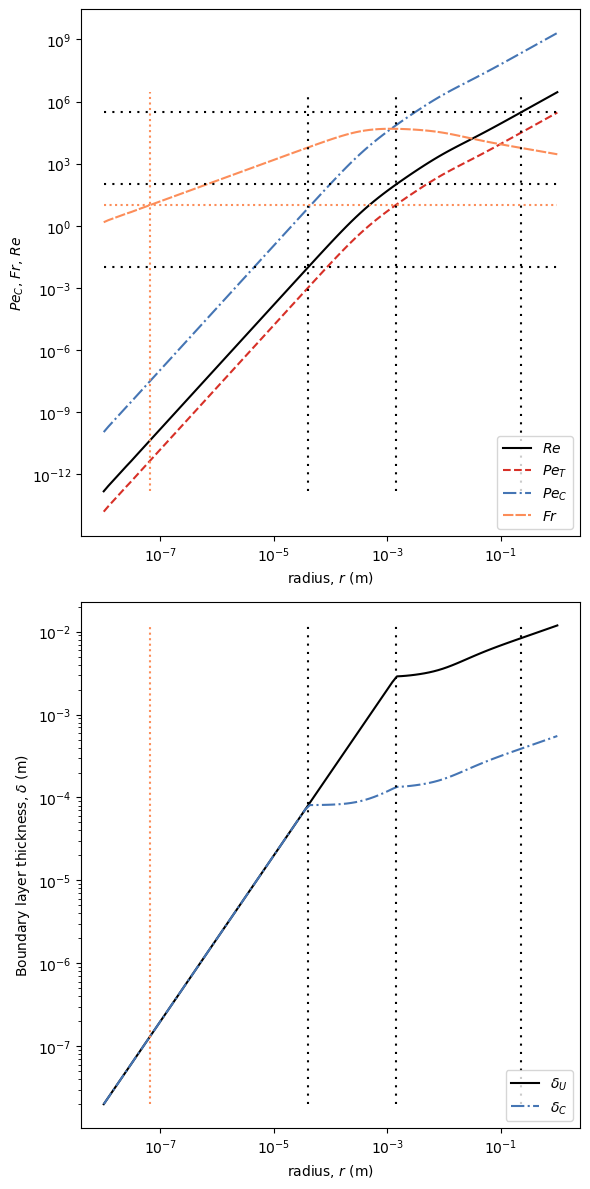

In [3]:
# Do calculation for some radii
r = np.logspace(-8,0,num=100)

# Estimated typical F-layer properties
kinematic_viscosity = 0.8E-6     # kinematic viscosity
gravity = 4.4                    # At ICB
rho_l = 12100                    # liquid density
rho_s = 12700                    # solid density
delta_density = rho_s - rho_l
k     = 70.0                     # thermal conductivity of liquid iron
cp    = 750                      # specific heat
thermal_diffusivity = k/(rho_l*cp)# thermal diffusivity of liquid
chemical_diffusivity = 1.1e-9      # self-diffusion of O in liquid


# Calculation of all properties as a function of radius (this is vectorised)
# We deliberatly extend outside domain where the emprical relations are valid
# so turn off the warning for this.
falling_velocity, drag_coefficient, re, pe_t, pe_c, fr, \
    delta_u, delta_c = falling.zhang_particle_dynamics(r, 
            kinematic_viscosity, gravity, delta_density, rho_l,
            thermal_diffusivity, chemical_diffusivity, brunt_vaisala=0.0004, warn_reynolds=False)

# Find 'critical' radii for the falling sphere - radii where the boundary layer 
# thickness scaling changes. This is only needed for plotting
r_re_low, r_re_int, r_re_max, r_fr_low = falling.find_critical_radii( 
                                         kinematic_viscosity, gravity, delta_density, rho_l,
                                         thermal_diffusivity, chemical_diffusivity, brunt_vaisala=0.0004)
print("Critical r values:", r_re_low, r_re_int, r_re_max, r_fr_low)
falling_velocity_max, _, _ = falling.self_consistent_falling_velocity(r_re_max, kinematic_viscosity, 
                                                gravity, delta_density, rho_l)
print("Maximum falling velocituy:", falling_velocity_max)

thecolors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']

# Plotting results. 8" wide and 600 dpi (approx A4, which is what we want)
fig, axs = plt.subplots(nrows=2, figsize=(6,12), tight_layout=True)

ax = axs[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r, re, label="$Re$", color="black")
ax.plot(r, pe_t, label="$Pe_T$", linestyle='--', color=thecolors[0])
ax.plot(r, pe_c, label="$Pe_C$", linestyle='-.', color=thecolors[4])
ax.plot(r, fr, label="$Fr$", linestyle=(0, (5,1)), color=thecolors[1])
# Re regimes
ax.hlines([3.0E5, 1.0E2, 1.0E-2], r[0], r[-1], color="black", linestyle=(0, (1,3)))
ax.vlines([r_re_low, r_re_int, r_re_max], re[0], re[-1], color="black", linestyle=(0, (1,3)))
# Change in Fr regime
ax.hlines([10.0], r[0], r[-1], linestyle=':', color=thecolors[1]) 
ax.vlines([r_fr_low], re[0], re[-1], linestyle=':', color=thecolors[1]) 

ax.set_xlabel('radius, $r$ (m)')
ax.set_ylabel('$Pe_C$, $Fr$, $Re$')
ax.legend(loc=4)

ax = axs[1]
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r, delta_u, label="$\delta_U$", color="black")
ax.plot(r, delta_c, label="$\delta_C$", linestyle='-.', color=thecolors[4])
# Re regimes
ax.vlines([r_re_low, r_re_int, r_re_max], delta_u[0], delta_u[-1], color="black", linestyle=(0, (1,3)))
# Change in Fr regime
ax.vlines([r_fr_low], delta_u[0], delta_u[-1], linestyle=':', color=thecolors[1]) 
ax.set_xlabel('radius, $r$ (m)')
ax.set_ylabel('Boundary layer thickness, $\delta$ (m)')
ax.legend(loc=4)

plt.show()

## Figure 3

The cell below generates Figure 3. This is a simplified version of the figures above.

/Users/andreww/Code/slurry/falling.py:171: UserWarning: Low Pe_c (1.36e+01 < 100) with intermediate or high Re (1.36e-02 > 0.01). Treat boundary layer results with care!
  warnings.warn(f"Low Pe_c ({pe_c:.2e} < 100) with intermediate or high Re ({re:.2e} > 0.01). Treat boundary layer results with care!")
/Users/andreww/Code/slurry/falling.py:171: UserWarning: Low Pe_c (2.37e+01 < 100) with intermediate or high Re (2.37e-02 > 0.01). Treat boundary layer results with care!
  warnings.warn(f"Low Pe_c ({pe_c:.2e} < 100) with intermediate or high Re ({re:.2e} > 0.01). Treat boundary layer results with care!")
/Users/andreww/Code/slurry/falling.py:171: UserWarning: Low Pe_c (4.13e+01 < 100) with intermediate or high Re (4.13e-02 > 0.01). Treat boundary layer results with care!
  warnings.warn(f"Low Pe_c ({pe_c:.2e} < 100) with intermediate or high Re ({re:.2e} > 0.01). Treat boundary layer results with care!")
/Users/andreww/Code/slurry/falling.py:171: UserWarning: Low Pe_c (7.16e+01 < 100) 

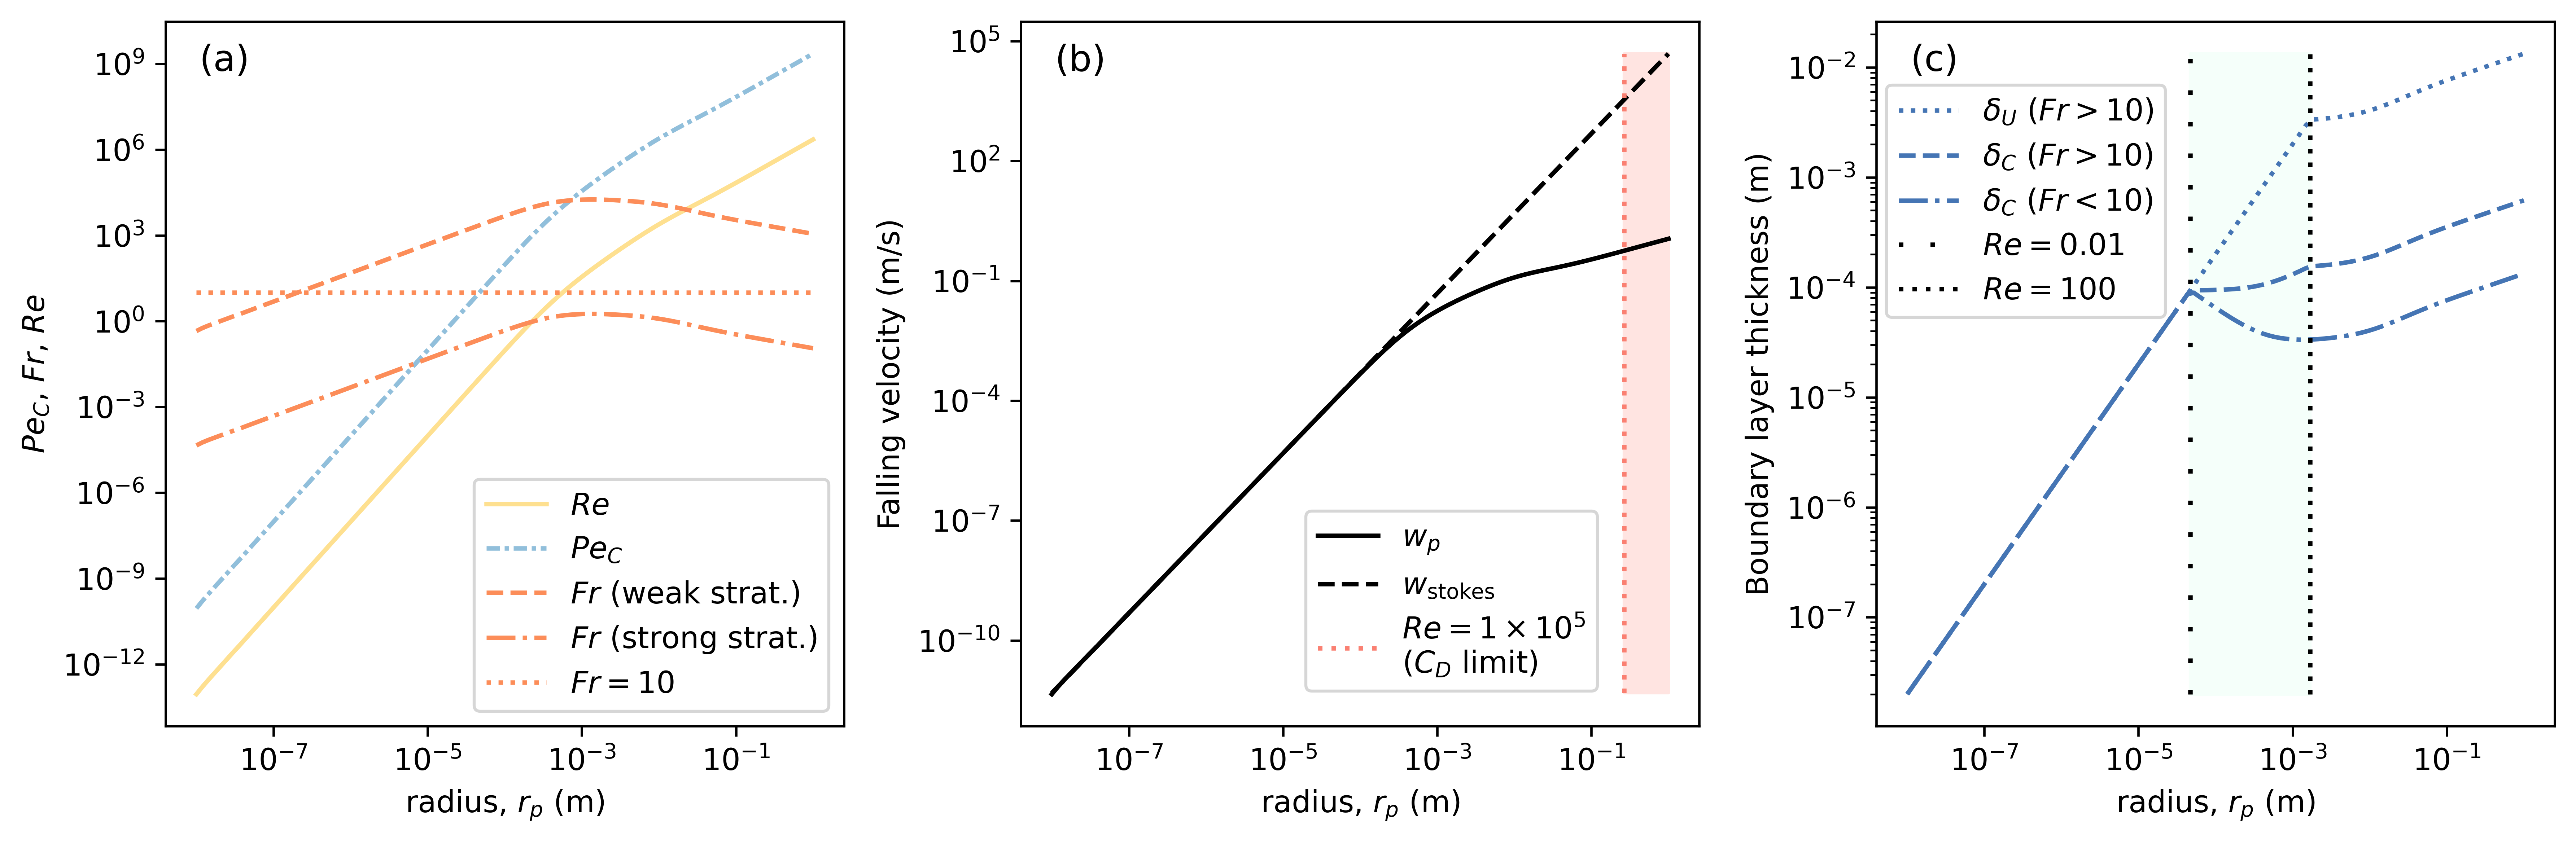

In [4]:
# Do calculation for some radii
r = np.logspace(-8,0,num=100)

# Estimated typical F-layer properties
kinematic_viscosity = 1.0E-6     # kinematic viscosity
gravity = 4.4                    # At ICB
rho_l = 12100                    # liquid density
rho_s = 12700                    # solid density
delta_density = rho_s - rho_l
k     = 100.0                    # thermal conductivity of solid iron
cp    = 750                      # specific heat
thermal_diffusivity = k/(rho_l*cp)# thermal diffusivity of liquid
chemical_diffusivity = 1e-9      # self-diffusion of O in liquid


# Calculation of properties (this is vectorised)
falling_velocity, drag_coefficient, re, pe_t, pe_c, fr, \
    delta_u, delta_c = falling.zhang_particle_dynamics(r, 
            kinematic_viscosity, gravity, delta_density, rho_l,
            thermal_diffusivity, chemical_diffusivity, warn_reynolds=False,
                                                               brunt_vaisala=0.001)

# Stokes velocity - for comparison
stokes_velocity = falling.stokes_falling_velocity(r, kinematic_viscosity,
                                                gravity, delta_density, rho_l)

# Find 'critical' radii for the falling sphere - radii where the boundary layer 
# thickness scaling changes. This is only needed for plotting
r_re_low, r_re_int, r_re_max, r_fr_low = falling.find_critical_radii( 
                                         kinematic_viscosity, gravity, delta_density, rho_l,
                                         thermal_diffusivity, chemical_diffusivity)

# Calculation of properties (this is vectorised)
_, _, _, _, _, fr_low, _, delta_c_low_fr = falling.zhang_particle_dynamics(r, 
            kinematic_viscosity, gravity, delta_density, rho_l,
            thermal_diffusivity, chemical_diffusivity, warn_reynolds=False,
                                                              brunt_vaisala=10.0)


# Plotting results. 8" wide and 600 dpi (approx A4, which is what we want)
fig, axs = plt.subplots(ncols=3, figsize=(12,4), dpi=600, tight_layout=True)
thecolors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']


ax = axs[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r, re, label="$Re$", color=thecolors[2])
ax.plot(r, pe_c, label="$Pe_C$", linestyle=(0, (3, 1, 1, 1)), color=thecolors[3])
ax.plot(r, fr, label="$Fr$ (weak strat.)", linestyle='--', color=thecolors[1])
ax.plot(r, fr_low, label="$Fr$ (strong strat.)", linestyle='-.', color=thecolors[1])
# Re regimes
#ax.hlines([1.0E-2], r[0], r[-1], color="black", linestyle=(0, (1,6)))
#ax.hlines([1.0E2], r[0], r[-1], color="black", linestyle=(0, (1,2)))
#ax.hlines([3.0E5], r[0], r[-1], color="salmon", linestyle=(0, (1,2)))
# Change in Fr regime
ax.hlines([10.0], r[0], r[-1], linestyle=':', color=thecolors[1], label='$Fr = 10$') 
ax.set_xlabel('radius, $r_p$ (m)')
ax.set_ylabel('$Pe_C$, $Fr$, $Re$')
ax.legend(loc=4)

ax = axs[1]
ax.plot(r, falling_velocity, label="$w_p$", color='black', linestyle='-')
ax.plot(r, stokes_velocity, label="$w_{\mathrm{stokes}}$", color='black', linestyle='--')
ax.vlines(r_re_max, ymin=stokes_velocity[0], ymax=stokes_velocity[-1],
           color='salmon', linestyle=(0, (1,2)), label='$Re = 1\\times10^5$\n($C_D$ limit)')
ax.fill_between([r_re_max, r[-1]], [stokes_velocity[-1], stokes_velocity[-1]],
                [stokes_velocity[0], stokes_velocity[0]], color='mistyrose')
ax.legend(loc=(0.42,0.05))
ax.set_xlabel('radius, $r_p$ (m)')
ax.set_ylabel('Falling velocity (m/s)')

ax.set_xscale('log')
ax.set_yscale('log')

ax = axs[2]
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r, delta_u, label="$\delta_U$ ($Fr > 10$)", linestyle=':', color=thecolors[4])
ax.plot(r, delta_c, label="$\delta_C$ ($Fr > 10$)", linestyle='--', color=thecolors[4])
ax.plot(r, delta_c_low_fr, label="$\delta_C$ ($Fr < 10$)", linestyle='-.', color=thecolors[4])
# Re regimes
ax.vlines([r_re_low], delta_u[0], delta_u[-1], color="black", linestyle=(0, (1,6)), label='$Re = 0.01$')
ax.vlines([r_re_int], delta_u[0], delta_u[-1], color="black", linestyle=(0, (1,2)), label='$Re = 100$')
ax.fill_between([r_re_low, r_re_int], [delta_u[-1], delta_u[-1]],
                [delta_u[0], delta_u[0]], color='mintcream')

ax.legend(loc=(0.015, 0.58))

ax.set_xlabel('radius, $r_p$ (m)')
ax.set_ylabel('Boundary layer thickness (m)')

axs[0].annotate("(a)", xy=(0.05, 0.93), xycoords="axes fraction", fontsize='large')
axs[1].annotate("(b)", xy=(0.05, 0.93), xycoords="axes fraction", fontsize='large')
axs[2].annotate("(c)", xy=(0.05, 0.93), xycoords="axes fraction", fontsize='large')

plt.show()

**Figure 2:** dynamical regime, falling velocity and boundary layer thickness for a iron particle falling
through the F-layer using parameters given in Table 1. (a) $Re$ (black) and $Fr$ (long dashed orange) are
calculated self consistently and determine the dynamical regime with transitions indicated by the horizontal
dotted lines at $Re = 10^{-2}$, $Re = 10^2$ and $Fr = 10$. The horizontal line at $Re = 3\times10^5$ is the upper
bound on the emprical scaling for the drag coefficent while $Pe_C$ is shown by the dashed blue line. (b) Falling
velocity (solid line) and Stokes velocity (dashed line) showing the divergence at larger radii. (c) Momentum 
(solid black line) and chemical (dashed blue line) boundary layer thicknes showing the intermediate and large
$Re$ regimes. In (b) and (c) the radii corresponding to critical values for $Re$ and $Fr$ are indicated with
vertical dotted lines.